#RNN


In [42]:
from  cmath import tanh,exp

def add(x, y):
    return x + y

def mul(x, y):
    return x * y

def two_matrix_add(x, y):
    result = []
    for i in xrange(len(x)):
        result.append(list(map(lambda t: reduce(add, t), zip(x[i], y[i]))))
    return result

def matrix_add(matrix_list):
    return reduce(two_matrix_add, matrix_list)

def VecMul(A,B):
    assert(len(A) == len(B))
    return sum(map(mul, A, B))

def MatMul(A,B):
    return [[sum(a * b for a, b in zip(a, b)) for b in zip(*B)] for a in A]

A = [1,2,3,4,5]
B = [1,2,3,4,5]
C = [[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5]]
print(VecMul(A,B))
print(MatMul(list([B]),C))
print(two_matrix_add(C,C))

55
[[15, 30, 45, 60, 75]]
[[2, 4, 6, 8, 10], [2, 4, 6, 8, 10], [2, 4, 6, 8, 10], [2, 4, 6, 8, 10], [2, 4, 6, 8, 10]]


In [81]:
class rnnCellState():
    def __init__(self, h_length, x_dim=1, hiden=2):
        self.Whi = [[0.01 for each in xrange(h_length + x_dim)]] * hiden
        self.Who = [0.01 for each in xrange(hiden)]
        self.Wo1 = [[0.01] for each in xrange(hiden)]
        self.Wy  = 0.01

class rnnCell():
    def __init__(self, h_length, x_dim=1, hiden=2):
        self.state = rnnCellState(h_length, x_dim, hiden)
        self.h0 = [0.01 for each in xrange(h_length)]
        self.h1 = [0.01 for each in xrange(h_length)]
        self.Y = None
        
    def forward(self,X,h0=None):
        if h0:self.h0=h0
        
        D0=self.h0[:]
        D0.append(X)
        
        D1 = MatMul(list([D0]),self.state.Whi)
        #print(D1)
        D2 = two_matrix_add(D1,[self.state.Who])
        #print(D2)
        D3 = MatMul(D2,self.state.Wo1)[0][0]
        #print(D3)
        self.Y = D3 + self.state.Wy
        
    def backward(self,Y):


S=rnnCellState(5)
print S.Whi
print S.Who
print S.Wo1

print MatMul(list([S.Who]),S.Wo1)

[[0.01, 0.01, 0.01, 0.01, 0.01, 0.01], [0.01, 0.01, 0.01, 0.01, 0.01, 0.01]]
[0.01, 0.01]
[[0.01], [0.01]]
[[0.0002]]


In [82]:
a = rnnCell(2)

In [83]:
a.forward(1)

[[0.0002, 0.0002, 0.0002]]
[[0.0102, 0.0102]]
0.000204


In [84]:
a = [1,2,3]
b = 3.14
a.append(b)
del a[-1]
print b
print a

3.14
[1, 2, 3]


In [208]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import random

import numpy as np
import math

def sigmoid(x): 
    return 1. / (1 + np.exp(-x))

def sigmoid_derivative(values): 
    return values*(1-values)

def tanh_derivative(values): 
    return 1. - values ** 2

# createst uniform random array w/ values in [a,b) and shape args
def rand_arr(a, b, *args): 
    np.random.seed(0)
    return np.random.rand(*args) * (b - a) + a

class LstmParam:
    def __init__(self, mem_cell_ct, x_dim):
        self.mem_cell_ct = mem_cell_ct
        self.x_dim = x_dim
        concat_len = x_dim + mem_cell_ct
        # weight matrices
        self.wg = rand_arr(-0.1, 0.1, mem_cell_ct, concat_len)
        self.wi = rand_arr(-0.1, 0.1, mem_cell_ct, concat_len) 
        self.wf = rand_arr(-0.1, 0.1, mem_cell_ct, concat_len)
        self.wo = rand_arr(-0.1, 0.1, mem_cell_ct, concat_len)
        # bias terms
        self.bg = rand_arr(-0.1, 0.1, mem_cell_ct) 
        self.bi = rand_arr(-0.1, 0.1, mem_cell_ct) 
        self.bf = rand_arr(-0.1, 0.1, mem_cell_ct) 
        self.bo = rand_arr(-0.1, 0.1, mem_cell_ct) 
        # diffs (derivative of loss function w.r.t. all parameters)
        self.wg_diff = np.zeros((mem_cell_ct, concat_len)) 
        self.wi_diff = np.zeros((mem_cell_ct, concat_len)) 
        self.wf_diff = np.zeros((mem_cell_ct, concat_len)) 
        self.wo_diff = np.zeros((mem_cell_ct, concat_len)) 
        self.bg_diff = np.zeros(mem_cell_ct) 
        self.bi_diff = np.zeros(mem_cell_ct) 
        self.bf_diff = np.zeros(mem_cell_ct) 
        self.bo_diff = np.zeros(mem_cell_ct) 

    def apply_diff(self, lr = 1):
        self.wg -= lr * self.wg_diff
        self.wi -= lr * self.wi_diff
        self.wf -= lr * self.wf_diff
        self.wo -= lr * self.wo_diff
        self.bg -= lr * self.bg_diff
        self.bi -= lr * self.bi_diff
        self.bf -= lr * self.bf_diff
        self.bo -= lr * self.bo_diff
        # reset diffs to zero
        self.wg_diff = np.zeros_like(self.wg)
        self.wi_diff = np.zeros_like(self.wi) 
        self.wf_diff = np.zeros_like(self.wf) 
        self.wo_diff = np.zeros_like(self.wo) 
        self.bg_diff = np.zeros_like(self.bg)
        self.bi_diff = np.zeros_like(self.bi) 
        self.bf_diff = np.zeros_like(self.bf) 
        self.bo_diff = np.zeros_like(self.bo) 

class LstmState:
    def __init__(self, mem_cell_ct, x_dim):
        self.g = np.zeros(mem_cell_ct)
        self.i = np.zeros(mem_cell_ct)
        self.f = np.zeros(mem_cell_ct)
        self.o = np.zeros(mem_cell_ct)
        self.s = np.zeros(mem_cell_ct)
        self.h = np.zeros(mem_cell_ct)
        self.bottom_diff_h = np.zeros_like(self.h)
        self.bottom_diff_s = np.zeros_like(self.s)
    
class LstmNode:
    def __init__(self, lstm_param, lstm_state):
        # store reference to parameters and to activations
        self.state = lstm_state
        self.param = lstm_param
        # non-recurrent input concatenated with recurrent input
        self.xc = None

    def bottom_data_is(self, x, s_prev = None, h_prev = None):
        # if this is the first lstm node in the network
        if s_prev is None: s_prev = np.zeros_like(self.state.s)
        if h_prev is None: h_prev = np.zeros_like(self.state.h)
        # save data for use in backprop
        self.s_prev = s_prev
        self.h_prev = h_prev

        # concatenate x(t) and h(t-1)
        xc = np.hstack((x,  h_prev))
        self.state.g = np.tanh(np.dot(self.param.wg, xc) + self.param.bg)
        self.state.i = sigmoid(np.dot(self.param.wi, xc) + self.param.bi)
        self.state.f = sigmoid(np.dot(self.param.wf, xc) + self.param.bf)
        self.state.o = sigmoid(np.dot(self.param.wo, xc) + self.param.bo)
        self.state.s = self.state.g * self.state.i + s_prev * self.state.f
        self.state.h = self.state.s * self.state.o

        self.xc = xc
    
    def top_diff_is(self, top_diff_h, top_diff_s):
        # notice that top_diff_s is carried along the constant error carousel
        ds = self.state.o * top_diff_h + top_diff_s
        do = self.state.s * top_diff_h
        di = self.state.g * ds
        dg = self.state.i * ds
        df = self.s_prev * ds

        # diffs w.r.t. vector inside sigma / tanh function
        di_input = sigmoid_derivative(self.state.i) * di 
        df_input = sigmoid_derivative(self.state.f) * df 
        do_input = sigmoid_derivative(self.state.o) * do 
        dg_input = tanh_derivative(self.state.g) * dg

        # diffs w.r.t. inputs
        self.param.wi_diff += np.outer(di_input, self.xc)
        self.param.wf_diff += np.outer(df_input, self.xc)
        self.param.wo_diff += np.outer(do_input, self.xc)
        self.param.wg_diff += np.outer(dg_input, self.xc)
        self.param.bi_diff += di_input
        self.param.bf_diff += df_input       
        self.param.bo_diff += do_input
        self.param.bg_diff += dg_input       

        # compute bottom diff
        dxc = np.zeros_like(self.xc)
        dxc += np.dot(self.param.wi.T, di_input)
        dxc += np.dot(self.param.wf.T, df_input)
        dxc += np.dot(self.param.wo.T, do_input)
        dxc += np.dot(self.param.wg.T, dg_input)

        # save bottom diffs
        self.state.bottom_diff_s = ds * self.state.f
        self.state.bottom_diff_h = dxc[self.param.x_dim:]

class LstmNetwork():
    def __init__(self, lstm_param):
        self.lstm_param = lstm_param
        self.lstm_node_list = []
        # input sequence
        self.x_list = []

    def y_list_is(self, y_list, loss_layer):
        """
        Updates diffs by setting target sequence 
        with corresponding loss layer. 
        Will *NOT* update parameters.  To update parameters,
        call self.lstm_param.apply_diff()
        """
        assert len(y_list) == len(self.x_list)
        idx = len(self.x_list) - 1
        # first node only gets diffs from label ...
        loss = loss_layer.loss(self.lstm_node_list[idx].state.h, y_list[idx])
        diff_h = loss_layer.bottom_diff(self.lstm_node_list[idx].state.h, y_list[idx])
        # here s is not affecting loss due to h(t+1), hence we set equal to zero
        diff_s = np.zeros(self.lstm_param.mem_cell_ct)
        self.lstm_node_list[idx].top_diff_is(diff_h, diff_s)
        idx -= 1

        ### ... following nodes also get diffs from next nodes, hence we add diffs to diff_h
        ### we also propagate error along constant error carousel using diff_s
        while idx >= 0:
            loss += loss_layer.loss(self.lstm_node_list[idx].state.h, y_list[idx])
            diff_h = loss_layer.bottom_diff(self.lstm_node_list[idx].state.h, y_list[idx])
            diff_h += self.lstm_node_list[idx + 1].state.bottom_diff_h
            diff_s = self.lstm_node_list[idx + 1].state.bottom_diff_s
            self.lstm_node_list[idx].top_diff_is(diff_h, diff_s)
            idx -= 1 

        return loss

    def x_list_clear(self):
        self.x_list = []

    def x_list_add(self, x):
        self.x_list.append(x)
        if len(self.x_list) > len(self.lstm_node_list):
            # need to add new lstm node, create new state mem
            lstm_state = LstmState(self.lstm_param.mem_cell_ct, self.lstm_param.x_dim)
            self.lstm_node_list.append(LstmNode(self.lstm_param, lstm_state))

        # get index of most recent x input
        idx = len(self.x_list) - 1
        if idx == 0:
            # no recurrent inputs yet
            self.lstm_node_list[idx].bottom_data_is(x)
        else:
            s_prev = self.lstm_node_list[idx - 1].state.s
            h_prev = self.lstm_node_list[idx - 1].state.h
            self.lstm_node_list[idx].bottom_data_is(x, s_prev, h_prev)
#



class ToyLossLayer:
    """
    Computes square loss with first element of hidden layer array.
    """
    @classmethod
    def loss(self, pred, label):
        return (pred[0] - label) ** 2

    @classmethod
    def bottom_diff(self, pred, label):
        diff = np.zeros_like(pred)
        diff[0] = 2 * (pred[0] - label)
        return diff
    


In [239]:
def Sgsize(X):
    MAX = max(X)
    MIN = min(X)
    Len = MAX-MIN
    result = []
    for i in X:
        result.append((i-MIN)/float(Len))
    return MAX,MIN,result

def ReSize(MAX,MIN,X):
    result = []
    for i in X:
        result.append(i*float(MAX-MIN)+MIN)
    return result

def AVG(X):
    return sum(X)/float(len(X))

def DER(X):
    avg=AVG(X)
    sdsq =  sum([(i - avg) ** 2 for i in X])
    return sdsq / (len(X) - 1)

def STD(X):
    return DER(X) ** .5

def Pxs(X):
    PX=dict({})
    L=len(X)
    for each in X:  
        PX[each] = (1 + PX[each])/float(L) if each in PX else 1/float(L)            
    return PX
        
    

def diff(X,interval=2):
    df = list()
    for i in range(interval,len(X)):
        value = X[i] - X[i-interval]
        df.append(value)
    for each in range(interval):
        df.insert(each,X[each])
    return df

def rediff(X,interval=2):
    redf = list()
    for i in range(len(X)):
        if i<interval:redf.append(X[i])
        else:redf.append(redf[i-interval] + X[i])
    return redf

In [240]:
XX=[1,0,5,2,3,0,8,5,3]
print(AVG(XX))
print(Pxs(XX))


3.0
{0: 0.1234567901234568, 1: 0.1111111111111111, 2: 0.1111111111111111, 3: 0.1234567901234568, 5: 0.1234567901234568, 8: 0.1111111111111111}


[0.125, 0.0, 0.625, 0.25, 0.375, 0.0, 1.0, 0.625, 0.375]
0.004909026556126186


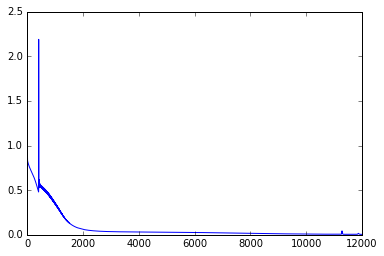

In [206]:
#XX=[1,0,5,2,3,0,8,5,3,12,0,5]
XX=[1,0,5,2,3,0,8,5,3]

YY=XX[1:] + [XX[0]]

mx,nx,xx=Sgsize(XX)
my,ny,yy=Sgsize(YY)

print(xx)

mem_cell_ct = 10
x_dim = 1
lstm_param = LstmParam(mem_cell_ct, x_dim)
lstm_net = LstmNetwork(lstm_param)
y_list = yy[:]
#input_val_arr = [np.mat(XX)]
input_val_arr = xx[:]

J = []
for cur_iter in xrange(12000):
    for ind in range(len(y_list)):
        lstm_net.x_list_add(input_val_arr[ind])
    loss = lstm_net.y_list_is(y_list, ToyLossLayer)
    J.append(loss)
    lstm_param.apply_diff(lr=0.04)
    lstm_net.x_list_clear()

print(loss)
plt.plot(J)

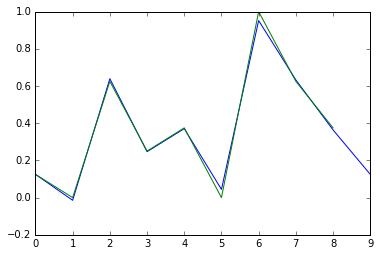

In [207]:
predict=[]
"""
for i in lstm_net.lstm_node_list:
    print(i.h_prev, i.state.h)
    print(i.s_prev, i.state.s)
"""

for ind in range(len(y_list)):
    lstm_net.x_list_add(input_val_arr[ind])
for ind in range(len(y_list)):
    predict.append(lstm_net.lstm_node_list[ind].state.h[0])

predict.insert(0,xx[0])
plt.plot(predict)
plt.plot(xx)